<a href="https://colab.research.google.com/github/Rio-HEPLab/EAFEXP2024/blob/main/Simulation_Muon_Flux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Lx: Detector width in x direction
# Ly: Detector width in y direction
# H: Height of top detector with respect to bottom detector
# In cm
Lx = 50.0
Ly = 50.0
H  = 30.0

# Number of tracks to simulate
Ntracks = 100000


Probabilidade em função do ângulo zenital e azimutal:

$$
\begin{align}
dp(\theta,\phi) &= \cos^2\theta \,d\Omega \\
                &= \cos^2\theta \,d(\cos\theta) \,d\phi \\
                &= \cos^2\theta \sin\theta \,d\theta \,d\phi
\end{align}
$$

#### Simulação de Monte Carlo (MC)

$$
\begin{align}
dp(\theta,\phi) = \cos^2\theta \sin\theta \,d\theta \,d\phi
\end{align}
$$

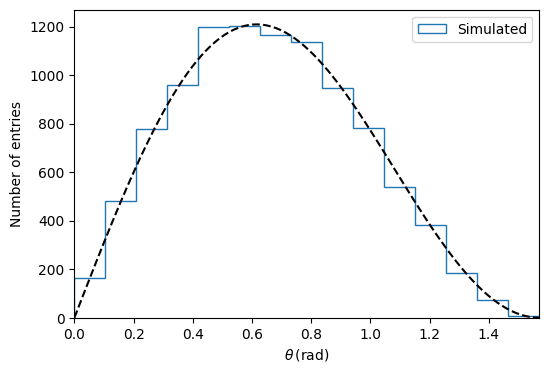

In [2]:
# Acceptance/rejection
# 1- Simulate theta according to cos^2(theta)sin(theta)

def simulate_theta( N = 1 ):

    vals = []

    for i in range( N ):
        one_theta = -999.
        while True:
            sample_theta_ = np.random.rand() * ( np.pi / 2 )
            sample_y_ = np.random.rand()
            cos2theta_ = ( np.cos( sample_theta_ ) ** 2 ) * np.sin( sample_theta_ )
            if sample_y_ < cos2theta_:
                one_theta = sample_theta_
                break
        vals.append( one_theta )

    return vals[0] if N == 1 else vals

vals_theta = simulate_theta( 10000 )

fig = plt.figure( figsize=(6,4) )

counts, bins, __ = plt.hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
plt.plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of entries' )
plt.legend( loc='best' )


Simulação de valores de $\cos\theta$:
$$
\begin{align}
dp(\cos\theta,\phi) = \cos^2\theta \,d(\cos\theta) \,d\phi \\
\end{align}
$$

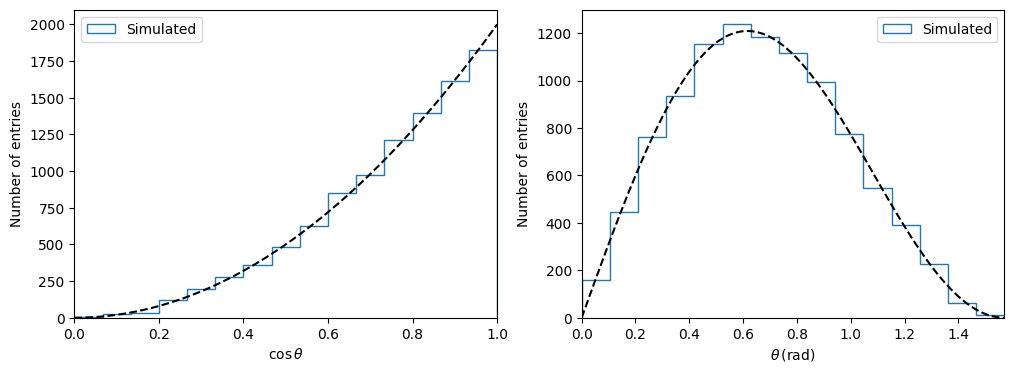

In [3]:
# Acceptance/rejection
# 2- Simulate cos(theta) according to cos^2(theta)

def simulate_costheta( N = 1 ):

    vals = []

    for i in range( N ):
        one_costheta = -999.
        while True:
            sample_costheta_ = np.random.rand()
            sample_y_ = np.random.rand()
            cos2theta_ = sample_costheta_ ** 2
            if sample_y_ < cos2theta_:
                one_costheta = sample_costheta_
                break
        vals.append( one_costheta )

    return vals[0] if N == 1 else vals

vals_costheta = simulate_costheta( 10000 )

# Convert to theta
vals_theta = np.arccos( vals_costheta )

# Plot as a function of cos(theta) and theta

fig, axes = plt.subplots( 1, 2, figsize=(2*6,4) )

counts, bins, __ = axes[0].hist( vals_costheta, range=(0,1), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., 1., 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
axes[0].plot( X__, ( ( integral_counts * bin_width / (1./3) ) * X__ ** 2 ), 'k--' )
axes[0].set_xlim( 0., 1. )
axes[0].set_xlabel( r'$\cos\theta$' )
axes[0].set_ylabel( 'Number of entries' )
axes[0].legend( loc='best' )

counts, bins, __ = axes[1].hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
axes[1].plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
axes[1].set_xlim( 0., np.pi/2 )
axes[1].set_xlabel( r'$\theta \,(\rm{rad})$' )
axes[1].set_ylabel( 'Number of entries' )
axes[1].legend( loc='best' )


Simulação a partir da distribuição cumulativa $F(\theta)$

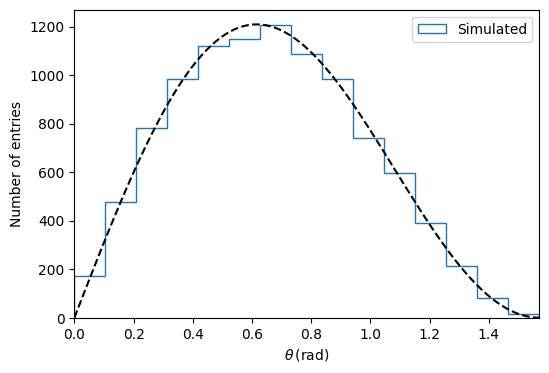

In [4]:
# Cumulative distribution of cos^2(x)sin(x)
def F( x ):
    return ( 1. - np.cos( x ) ** 3 )

# Sample cumulative distribution and invert (invertion can be performed with a lookup table, not done here)
def simulate_theta_cumulative( N = 1 ):

    vals = []

    for i in range( N ):
        val_y = np.random.rand()
        # Find x such y = F(x)
        opt_sol = optimize.root_scalar( ( lambda x: F( x ) - val_y ) , bracket=(0,np.pi/2) )
        one_theta = opt_sol.root

        vals.append( one_theta )

    return vals[0] if N == 1 else vals

vals_theta = simulate_theta_cumulative( 10000 )

fig = plt.figure( figsize=(6,4) )

counts, bins, __ = plt.hist( vals_theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
plt.plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of entries' )
plt.legend( loc='best' )

#### Simulação das trajetórias de partículas

In [5]:
# Simulate angles and position of tracks

def random_tracks( Ntracks ):
    '''
    Generates random tracks according to a cos²(theta) propability.
    Parameters:
    Ntracks: Number of tracks to generate.
    Returns:
    Arrays of zenithal angle, azimuthal angle, x and y positions.
    '''

    theta = [] #zenital angle
    phi = [] #azimutal angle
    x = [] #position in x
    y = [] #position in y

    for i in range( 0, Ntracks ):
        if i > 0 and i % 10000 == 0:
            print ( "{} tracks processed.".format( i ) )

        one_theta = simulate_theta()

        one_phi = np.random.rand() * ( 2*np.pi - 0 )

        one_x = np.random.uniform( 0, Lx )
        one_y = np.random.uniform( 0, Ly )

        theta.append(one_theta)
        phi.append(one_phi)
        x.append(one_x)
        y.append(one_y)

    return theta, phi, x, y


In [6]:
theta, phi, x, y = random_tracks( Ntracks )

10000 tracks processed.
20000 tracks processed.
30000 tracks processed.
40000 tracks processed.
50000 tracks processed.
60000 tracks processed.
70000 tracks processed.
80000 tracks processed.
90000 tracks processed.


#### Propagação para o detector inferior

In [7]:
# Propagate tracks from top to bottom detector

def propagate_to_bottom(theta, phi, x0, y0):
    '''
    Propagates a track with given direction and initial position to bottom plane.
    Parameters:
    theta (float): Zenital angle of the track trajectory, in radians.
    phi (float): Azimutal angle of the muon trajectory, in radians.
    x0, y0: X and Y initial track position in top plane.
    Returns:
    x and y position of the track in the bottom plane.
    '''
    d = H * np.tan( theta )
    deltaX = d * np.sin( phi )
    deltaY = d * np.cos( phi )
    x_bot, y_bot = (x0 + deltaX, y0 + deltaY)

    return x_bot, y_bot

x_bot_all = []
y_bot_all = []

count_tracks_in_acceptance = 0
theta_acc = []
for theta_, phi_, x0_, y0_ in zip(theta, phi, x, y):
    # Propagate track positions in bottom detector
    x_bot_rndm, y_bot_rndm = propagate_to_bottom( theta_, phi_, x0_, y0_ )
    # Save positions in arrays
    x_bot_all.append( x_bot_rndm )
    y_bot_all.append( y_bot_rndm )
    # Check if within acceptance of bottom detector
    if 0. < x_bot_rndm and x_bot_rndm < Lx:
        if 0 < y_bot_rndm and y_bot_rndm < Ly:
            count_tracks_in_acceptance += 1
            theta_acc.append( theta_ )

print ( "Number of tracks in acceptance: {} / {}".format( count_tracks_in_acceptance, Ntracks ) )


Number of tracks in acceptance: 45096 / 100000


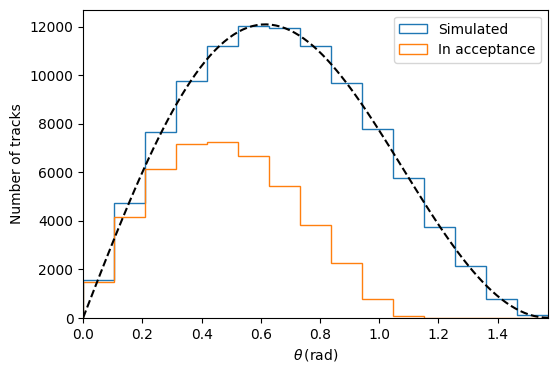

In [8]:
fig = plt.figure( figsize=(6,4) )

counts, bins, __ = plt.hist( theta, range=(0,np.pi/2), bins=15, histtype='step', label="Simulated" )
plt.hist( theta_acc, range=(0,np.pi/2), bins=15, histtype='step', label="In acceptance" )

X__ = np.linspace( 0., np.pi/2, 100 )
integral_counts = np.sum( counts )
bin_width = ( bins[1] - bins[0] )
plt.plot( X__, ( integral_counts * bin_width / (1./3) ) * np.sin( X__ ) * ( np.cos( X__ ) ** 2 ), 'k--' )
plt.xlim( 0., np.pi/2 )
plt.xlabel( r'$\theta \,(\rm{rad})$' )
plt.ylabel( 'Number of tracks' )
plt.legend( loc='best' )

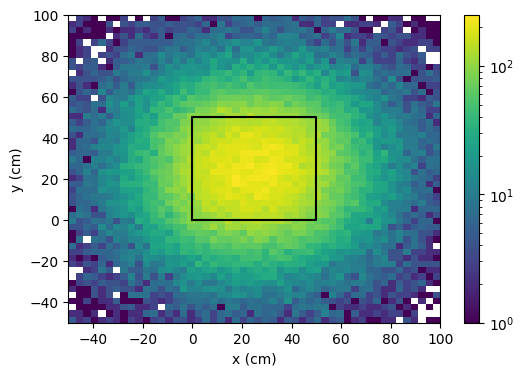

In [9]:
from matplotlib.colors import LogNorm
fig = plt.figure( figsize=(6,4) )
counts, xedges, yedges, im = plt.hist2d( x_bot_all, y_bot_all, bins=(50,50), range=( (-50.,100.), (-50.,100.) ), norm=LogNorm(), cmap='viridis' )
fig.colorbar(im, ax=plt.gca())
plt.plot( [ 0., Lx, Lx, 0., 0. ], [0., 0., Ly, Ly, 0. ], 'k-' )
plt.xlim( -50, 100 )
plt.ylim( -50, 100 )
plt.xlabel( 'x (cm)' )
plt.ylabel( 'y (cm)' )
plt.show()